http://www.ercot.com/gridinfo/load

The archives are also there:
http://www.ercot.com/gridinfo/load/load_hist

There is a difference between the archives and real time, as I have learned :) The real time is based on telemetry substation data, whereas the historical is based on final values. This usually accounts for about a 1% difference, mostly white noise. It would be a good exercise for students to both correct this historical bias and also build timeseries forecasting models on this live data feed. ERCOT also publishes their own load forecasts, so you can use that as a good baseline for any model.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

In [3]:
import pandas as pd
import numpy as np

In [4]:
!sudo -H pip3 install -U xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!sudo apt-get install unzip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [6]:
import datetime as dt

def str_to_datetime(date_str):
    if date_str.endswith("24:00"):
        return pd.to_datetime(date_str[:10], format="%m/%d/%Y") + dt.timedelta(days=1)
    else:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")

In [66]:
!curl "https://www.ercot.com/files/docs/2021/11/12/Native_Load_2021.zip" -o native_load_2021.zip
!unzip -o native_load_2021.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1068k  100 1068k    0     0  19.6M      0 --:--:-- --:--:-- --:--:-- 19.6M
Archive:  native_load_2021.zip
  inflating: Native_Load_2021.xlsx   


In [ ]:
df2021 = pd.read_excel("Native_Load_2021.xlsx")

In [69]:
df2021.dtypes

Hour Ending     object
COAST          float64
EAST           float64
FWEST          float64
NORTH          float64
NCENT          float64
SOUTH          float64
SCENT          float64
WEST           float64
ERCOT          float64
dtype: object

In [70]:
import re
for g in df2021["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/07/2021 02:00 DST


In [72]:
df2021["Hour Ending"].replace("11/07/2021 02:00 DST", "11/07/2021 02:00", inplace=True)

In [74]:
df2021['date'] = df2021["Hour Ending"].apply(str_to_datetime)
df2021.drop('Hour Ending', inplace=True, axis='columns')
df2021.set_index('date', inplace=True)

df2021.sort_index(inplace=True)

In [75]:
df2021

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
date,,,,,,,,,
2021-01-01 01:00:00,11047.018793,1517.435253,3978.220628,838.352810,13575.277728,3545.093310,7778.262533,1440.188560,43719.849616
2021-01-01 02:00:00,10954.470339,1523.683893,3975.757045,825.123437,13340.337915,3586.547882,7693.744119,1421.385715,43321.050347
2021-01-01 03:00:00,10883.657240,1519.800916,3969.812081,819.551228,13311.625189,3586.124059,7566.951524,1405.544826,43063.067063
2021-01-01 04:00:00,10926.482445,1523.472963,3983.487761,820.612439,13356.442066,3570.592369,7506.685527,1402.283632,43090.059203
2021-01-01 05:00:00,11019.796399,1565.625573,3980.940744,831.607158,13528.651487,3590.902242,7563.971854,1405.094618,43486.590073
...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,13926.775034,1566.583851,4192.977787,916.124441,11942.416165,3910.031058,7401.098687,1133.093917,44989.100940
2021-12-31 21:00:00,13498.908542,1549.687559,4149.062209,886.943872,11406.911057,3681.222926,7088.478765,1102.727285,43363.942215
2021-12-31 22:00:00,13116.012129,1515.852644,4148.330779,859.408149,10978.547227,3515.077507,6800.707246,1071.686005,42005.621687


### 2020

In [7]:
!curl "https://www.ercot.com/files/docs/2021/01/12/Native_Load_2020.zip" -o native_load_2020.zip
!unzip -o native_load_2020.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1074k  100 1074k    0     0  3159k      0 --:--:-- --:--:-- --:--:-- 3150k
Archive:  native_load_2020.zip
  inflating: Native_Load_2020.xlsx   


In [8]:
df2020 = pd.read_excel("Native_Load_2020.xlsx")
df2020

,HourEnding,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2020 01:00,9890.091522,1364.278198,3721.972022,773.878822,11719.863767,2707.841517,5473.246071,1172.943179,36824.115099
1,01/01/2020 02:00,9751.586415,1369.569694,3735.514034,775.063743,11639.455987,2706.844837,5387.380467,1165.951313,36531.366488
2,01/01/2020 03:00,9603.421087,1373.528720,3735.851866,774.153775,11515.421981,2650.378864,5270.331958,1149.076769,36072.165020
3,01/01/2020 04:00,9501.585599,1365.630426,3743.517881,778.097301,11518.359020,2586.709109,5200.960612,1141.301918,35836.161867
4,01/01/2020 05:00,9499.426925,1385.600323,3753.898979,784.077729,11649.293449,2548.852381,5230.298774,1147.094161,35998.542722
...,...,...,...,...,...,...,...,...,...,...
8779,12/31/2020 20:00,12068.071946,1788.474092,3979.115067,1005.372994,16508.360213,3718.100777,8640.867717,1640.840548,49349.203353
8780,12/31/2020 21:00,11818.903690,1726.770658,3962.905180,969.428095,15752.272222,3637.379800,8505.529827,1607.467424,47980.656897
8781,12/31/2020 22:00,11560.408167,1680.800823,3925.708218,928.517370,15179.536570,3571.725609,8334.601541,1573.542580,46754.840878
8782,12/31/2020 23:00,11339.877692,1627.080961,3895.376959,891.856675,14650.060694,3524.972799,8024.802495,1521.383987,45475.412261


In [9]:
df2020["HourEnding"].replace("11/01/2020 02:00 DST", "11/01/2020 02:00", inplace=True)
df2020['date'] = df2020["HourEnding"].apply(str_to_datetime)
df2020.drop('HourEnding', inplace=True, axis='columns')
df2020.set_index('date', inplace=True)

df2020.sort_index(inplace=True)

### 2019 

In [10]:
!curl "https://www.ercot.com/files/docs/2020/01/09/Native_Load_2019.zip" -o native_load_2019.zip
!unzip -o native_load_2019.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  2771k      0 --:--:-- --:--:-- --:--:-- 2771k
Archive:  native_load_2019.zip
  inflating: Native_Load_2019.xlsx   


In [11]:
df2019 = pd.read_excel("Native_Load_2019.xlsx")



In [12]:
import re
for g in df2019["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/03/2019 02:00 DST


In [13]:
df2019["HourEnding"].replace("11/03/2019 02:00 DST", "11/03/2019 02:00", inplace=True)

In [14]:
len(df2019)

8760

In [15]:
df2019['date'] = df2019["HourEnding"].apply(str_to_datetime)
df2019.drop('HourEnding', inplace=True, axis='columns')
df2019.set_index('date', inplace=True)

df2019.sort_index(inplace=True)

### 2018

In [16]:
!curl "https://www.ercot.com/files/docs/2019/01/07/native_load_2018.zip" -o native_load_2018.zip
!unzip -o native_load_2018.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  7907k      0 --:--:-- --:--:-- --:--:-- 7907k
Archive:  native_load_2018.zip
  inflating: Native_Load_2018.xlsx   


In [17]:
df2018 = pd.read_excel("Native_Load_2018.xlsx")


In [18]:
import re
for g in df2018["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/04/2018 02:00 DST


In [19]:
df2018["HourEnding"].replace("11/04/2018 02:00 DST", "11/04/2018 02:00", inplace=True)

In [20]:

df2018['date'] = df2018["HourEnding"].apply(str_to_datetime)
df2018.drop('HourEnding', inplace=True, axis='columns')
df2018.set_index('date', inplace=True)

### 2017

In [21]:
!curl "https://www.ercot.com/files/docs/2018/01/09/native_load_2017.zip" -o native_load_2017.zip
!unzip -o native_load_2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1093k  100 1093k    0     0  4222k      0 --:--:-- --:--:-- --:--:-- 4222k
Archive:  native_load_2017.zip
  inflating: native_Load_2017.xlsx   


In [22]:
df2017 = pd.read_excel("native_Load_2017.xlsx")

In [23]:
import re
for g in df2017["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/05/2017 02:00 DST


In [24]:
df2017["Hour Ending"].replace("11/05/2017 02:00 DST", "11/05/2017 02:00", inplace=True)

In [25]:
df2017['date'] = df2017["Hour Ending"].apply(str_to_datetime)
df2017.drop('Hour Ending', inplace=True, axis='columns')
df2017.set_index('date', inplace=True)

In [26]:
len(df2017)/24

365.0

### 2016

In [27]:
!curl "https://www.ercot.com/files/docs/2017/01/10/native_Load_2016.zip" -o native_load_2016.zip
!unzip -o native_load_2016.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1095k  100 1095k    0     0  2945k      0 --:--:-- --:--:-- --:--:-- 2945k
Archive:  native_load_2016.zip
  inflating: native_Load_2016.xlsx   


In [28]:
df2016 = pd.read_excel("native_Load_2016.xlsx")

In [29]:
df2016.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [30]:
df2016.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [31]:
df2016.set_index('date', inplace=True)

In [32]:
df2016 = df2016.fillna(method="ffill")

In [33]:
len(df2016)/24

366.0

### 2015

In [34]:
!curl "https://www.ercot.com/files/docs/2016/01/07/native_load_2015.xls" -o native_load_2015.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7058k      0 --:--:-- --:--:-- --:--:-- 7030k


In [35]:
df2015 = pd.read_excel("native_load_2015.xls")

In [36]:
df2015.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2015-01-01 01:00:00.003,9844.200268,1350.784678,2078.060021,901.770195,13640.024978,3607.904503,6731.301663,1470.814721,39624.861027
1,2015-01-01 01:59:59.997,9653.456269,1333.434943,2057.993265,890.150373,13425.121941,3609.619438,6602.935629,1440.832944,39013.544802
2,2015-01-01 03:00:00.000,9502.299659,1323.908498,2039.019542,880.926639,13286.070909,3573.158363,6530.663273,1430.495044,38566.541927


In [37]:
df2015.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [38]:
df2015.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [39]:
df2015.set_index('date', inplace=True)

In [40]:
len(df2015)/24

365.0

### 2014

In [41]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2014_ercot_hourly_load_data.xls" -o native_load_2014.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  4224k      0 --:--:-- --:--:-- --:--:-- 4214k


In [42]:
df2014 = pd.read_excel("native_load_2014.xls")

In [43]:
df2014.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2014-01-01 01:00:00.003,9101.691219,1338.197939,1820.206244,793.458458,12298.801147,3236.109065,6121.146143,1102.523505,35812.133719
1,2014-01-01 01:59:59.997,8907.975782,1328.940064,1809.180861,791.141630,12297.109823,3246.493375,6091.018850,1098.774771,35570.635156
2,2014-01-01 03:00:00.000,8738.460973,1317.990846,1804.524573,789.791906,12285.295247,3217.721388,6060.017515,1097.716762,35311.519210


In [44]:
df2014.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [45]:
df2014.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [46]:
df2014.set_index('date', inplace=True)

In [47]:
len(df2014)/24

365.0

### 2013

In [48]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2013_ercot_hourly_load_data.xls" -o native_load_2013.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  11.2M      0 --:--:-- --:--:-- --:--:-- 11.2M


In [49]:
df2013 = pd.read_excel("native_load_2013.xls")

In [50]:
df2013.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2013-01-01 01:00:00.003,7607.189871,1074.024285,1411.823159,763.069242,10370.322921,2206.945802,4368.528687,883.029500,28684.933467
1,2013-01-01 01:59:59.997,7389.267519,1035.189180,1403.601093,754.425986,10153.942806,2160.082197,4233.635250,872.532258,28002.676290
2,2013-01-01 03:00:00.000,7179.748411,1036.216739,1395.131213,746.215515,9989.243532,2065.369913,4082.897707,868.951334,27363.774363


In [51]:
df2013.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [52]:
df2013.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [53]:
df2013.set_index('date', inplace=True)

In [54]:
len(df2013)/24

365.0

### 2012

In [55]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2012_ercot_hourly_load_data.xls" -o native_load_2012.xls
df2012 = pd.read_excel("native_load_2012.xls")
df2012.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2012.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  5438k      0 --:--:-- --:--:-- --:--:-- 5421k


In [56]:
len(df2012)/24

366.0

### 2011



In [57]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2011_ercot_hourly_load_data.xls" -o native_load_2011.xls
df2011 = pd.read_excel("native_load_2011.xls")
df2011.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2011.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5064k      0 --:--:-- --:--:-- --:--:-- 5064k


In [58]:
len(df2011)/24

365.0

### 2010

In [59]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2010_ercot_hourly_load_data.xls" -o native_load_2010.xls
df2010 = pd.read_excel("native_load_2010.xls")
df2010.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2010.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  4801k      0 --:--:-- --:--:-- --:--:-- 4801k


In [60]:
len(df2010)/24

365.0

### 2009

In [61]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2009_ercot_hourly_load_data.xls" -o native_load_2009.xls
df2009 = pd.read_excel("native_load_2009.xls")
df2009.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2009.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0   240k      0  0:00:07  0:00:07 --:--:--  339k


In [ ]:
len(df2009)/24

365.0

### 2008

In [62]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2008_ercot_hourly_load_data.xls" -o native_load_2008.xls
df2008 = pd.read_excel("native_load_2008.xls")
df2008.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2008.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  1289k      0  0:00:01  0:00:01 --:--:-- 1289k


In [63]:
len(df2008)/24

366.0

### 2007

In [64]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2007_ercot_hourly_load_data.xls" -o native_load_2007.xls
df2007 = pd.read_excel("native_load_2007.xls")
df2007.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2007.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0   516k      0  0:00:03  0:00:03 --:--:--  516k


### Concatenate 

In [76]:
df = pd.concat([df2021, df2020, df2019, df2018, df2017, df2016, df2015, df2014, df2013, df2012, df2011, df2010, df2009, df2008, df2007], axis='index').sort_index()

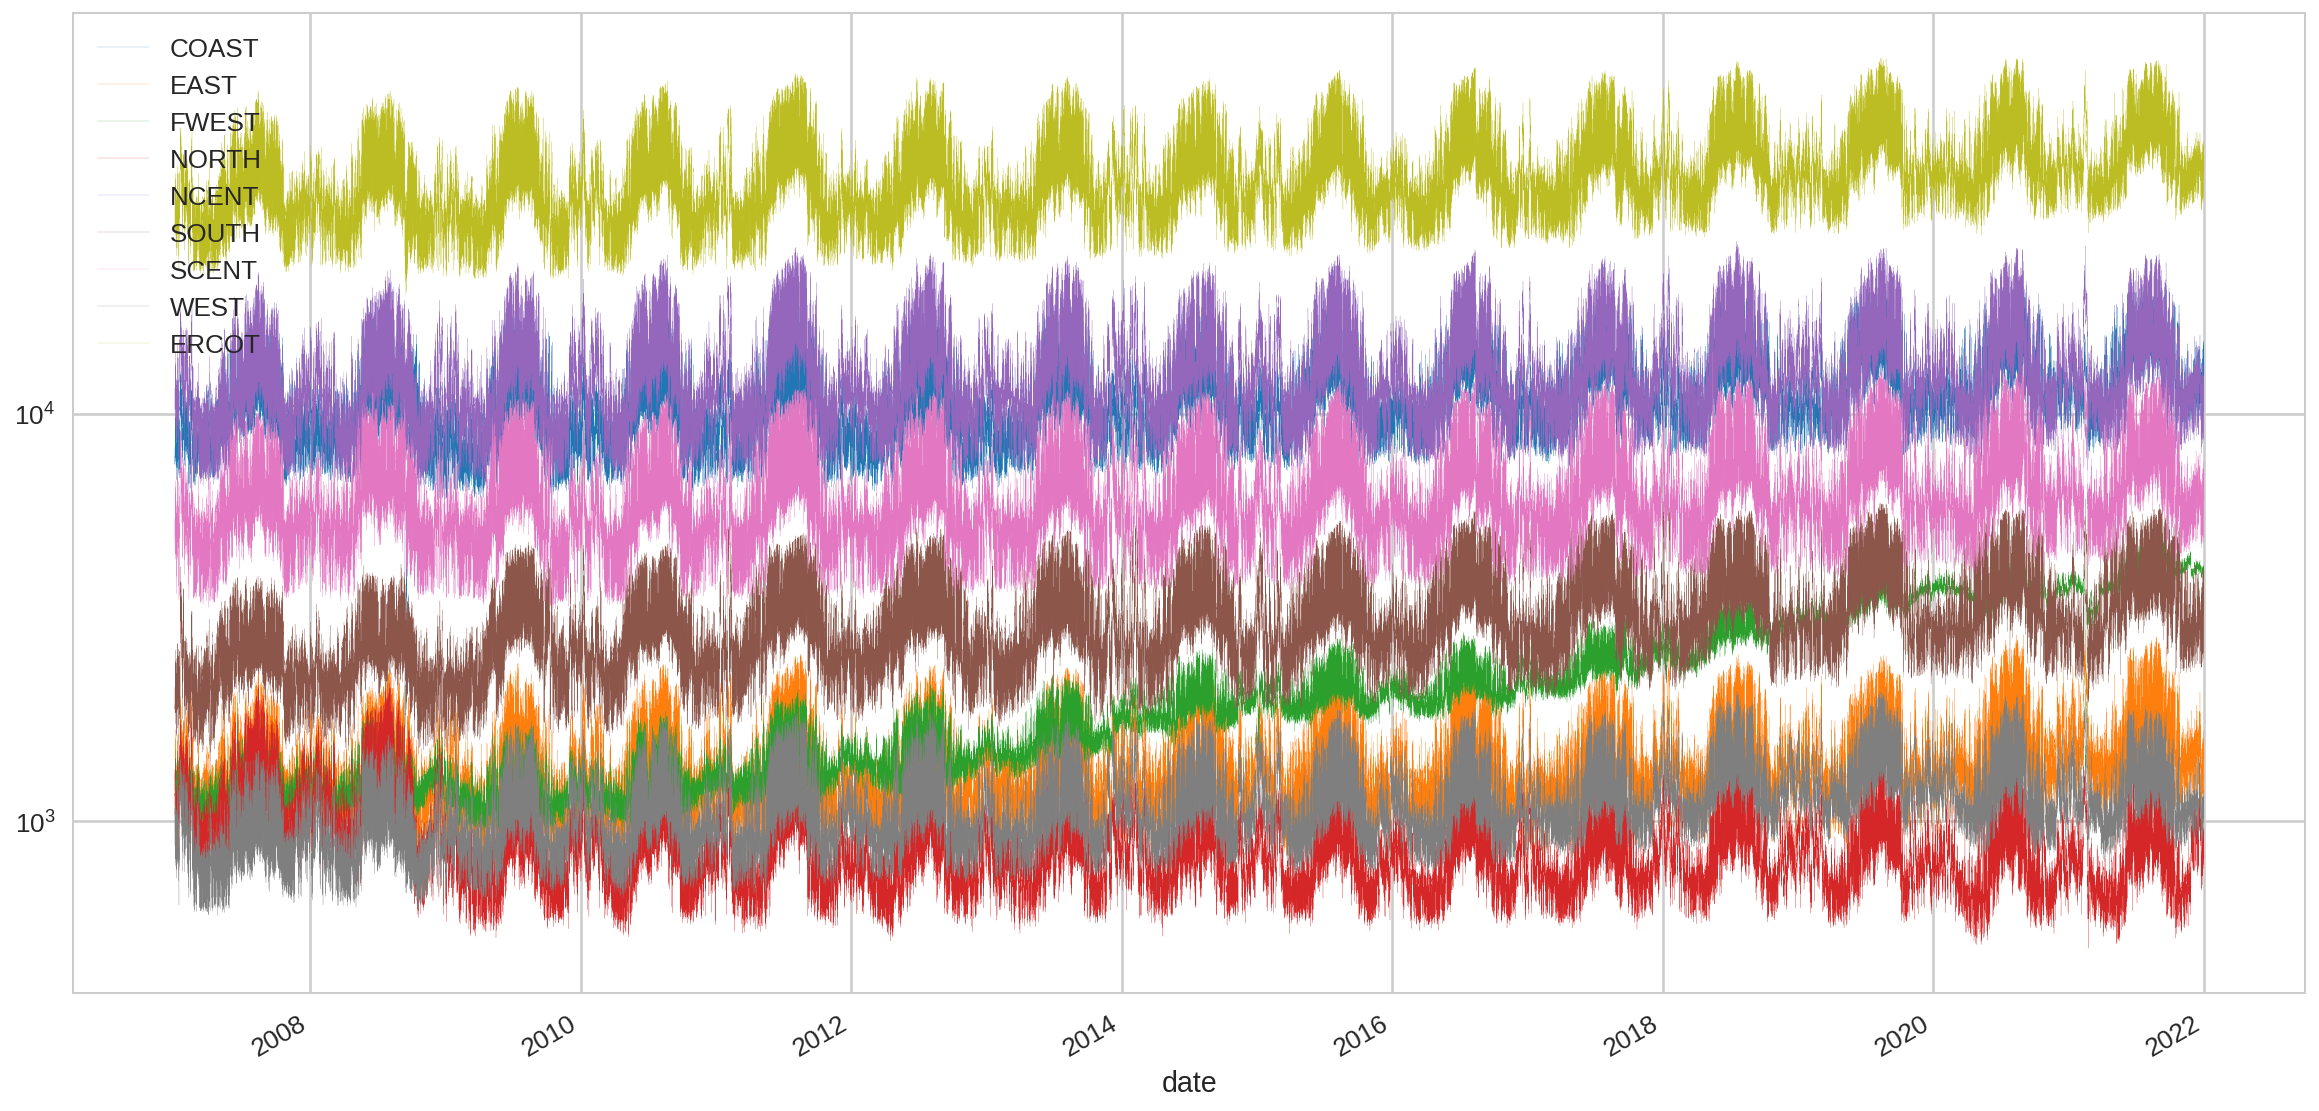

In [77]:
df.plot(figsize=(20,10), linewidth=0.1, logy=True)

In [78]:
len(df)

131496

In [79]:
df [ np.delete(df.columns.values.copy(), -1) ].sum().sum()

5164673885.347603

In [80]:
df.sum().ERCOT

5164735516.31335

In [94]:
df

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
date,,,,,,,,,
2007-01-01 01:00:00.003,7883.987618,1157.996001,1192.611809,1049.767230,10278.440568,1933.973511,4872.454048,870.272863,29239.503647
2007-01-01 01:59:59.997,7681.614678,1153.342085,1202.375412,1042.690867,10254.628659,1907.297022,4908.541918,879.240371,29029.731012
2007-01-01 03:00:00.000,7549.359777,1166.882378,1214.996069,1041.928347,10282.656844,1883.466870,4925.082296,891.610454,28955.983035
2007-01-01 04:00:00.003,7523.845385,1157.325672,1230.850179,1051.079763,10379.404402,1885.671400,4961.168487,907.227968,29096.573256
2007-01-01 04:59:59.997,7597.701504,1176.832481,1253.048925,1076.974779,10569.074587,1934.258865,5066.356434,933.981022,29608.228598
...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00.000,13926.775034,1566.583851,4192.977787,916.124441,11942.416165,3910.031058,7401.098687,1133.093917,44989.100940
2021-12-31 21:00:00.000,13498.908542,1549.687559,4149.062209,886.943872,11406.911057,3681.222926,7088.478765,1102.727285,43363.942215
2021-12-31 22:00:00.000,13116.012129,1515.852644,4148.330779,859.408149,10978.547227,3515.077507,6800.707246,1071.686005,42005.621687


## Extracting Seasonal Components: Daily, Weekly, Yearly

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


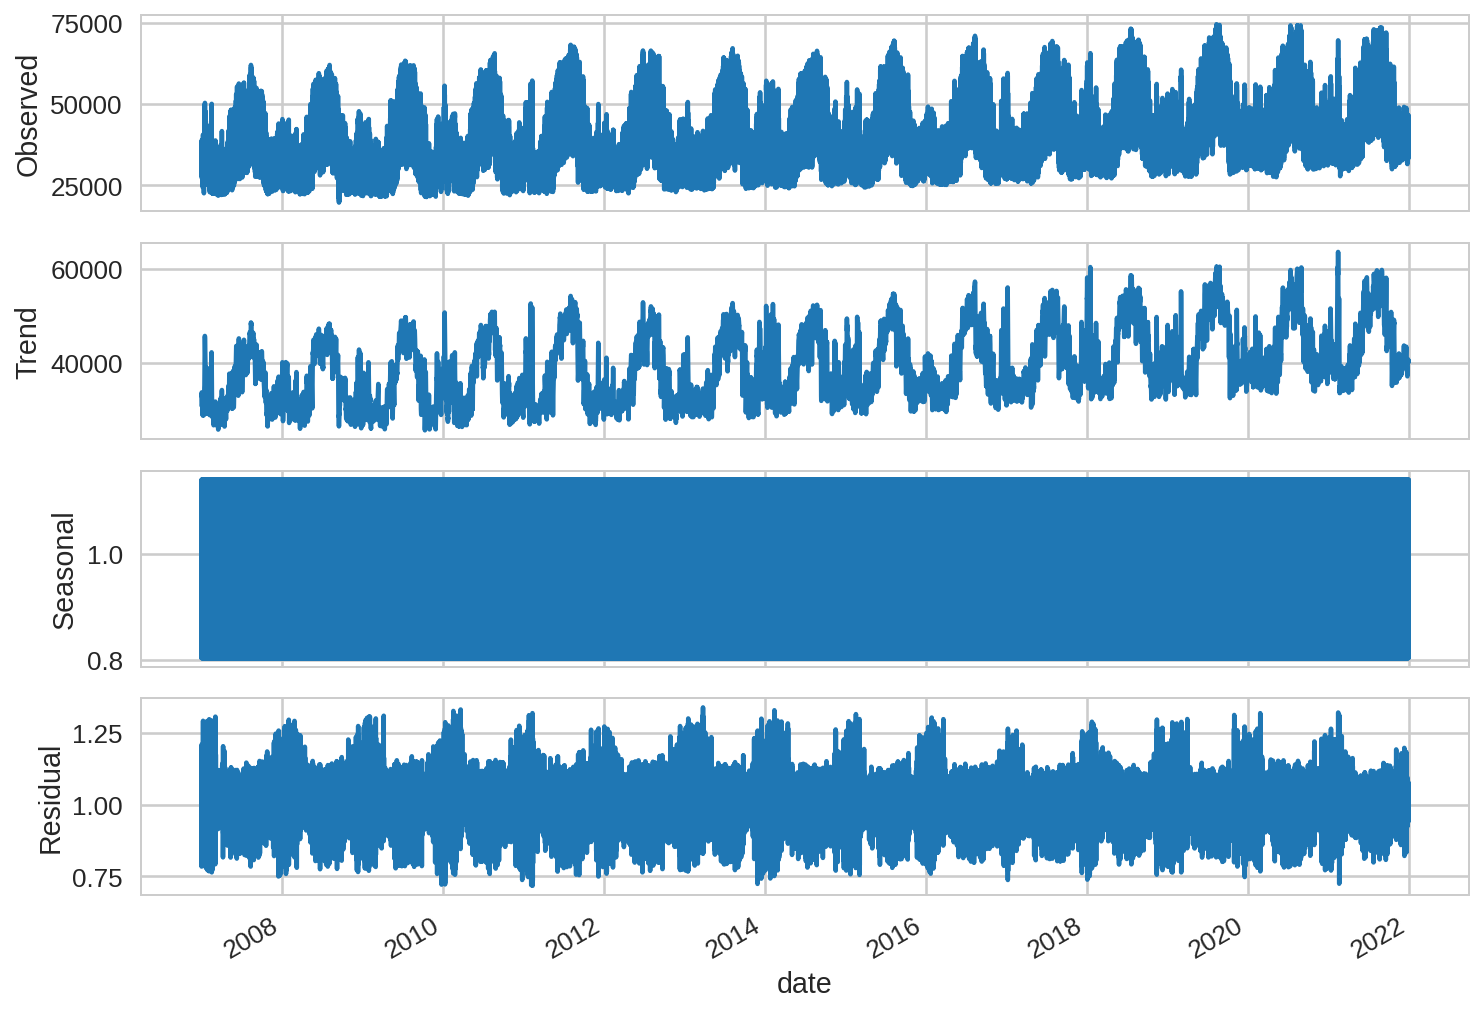

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
decomposition = seasonal_decompose(df.ERCOT, model='multiplicative', freq=24)  
fig = decomposition.plot()  

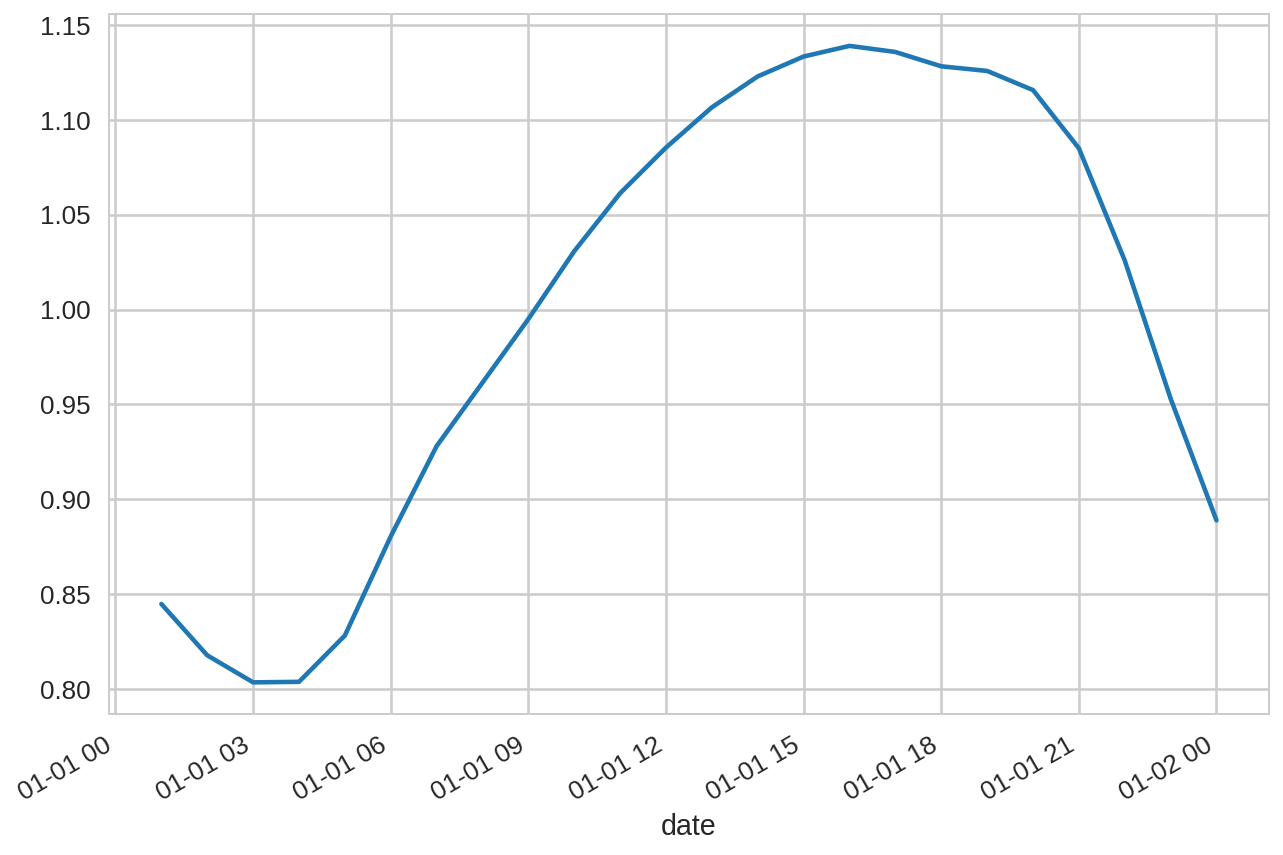

In [82]:
daily_seasonal = decomposition.seasonal.copy()
daily_seasonal[:24].plot()

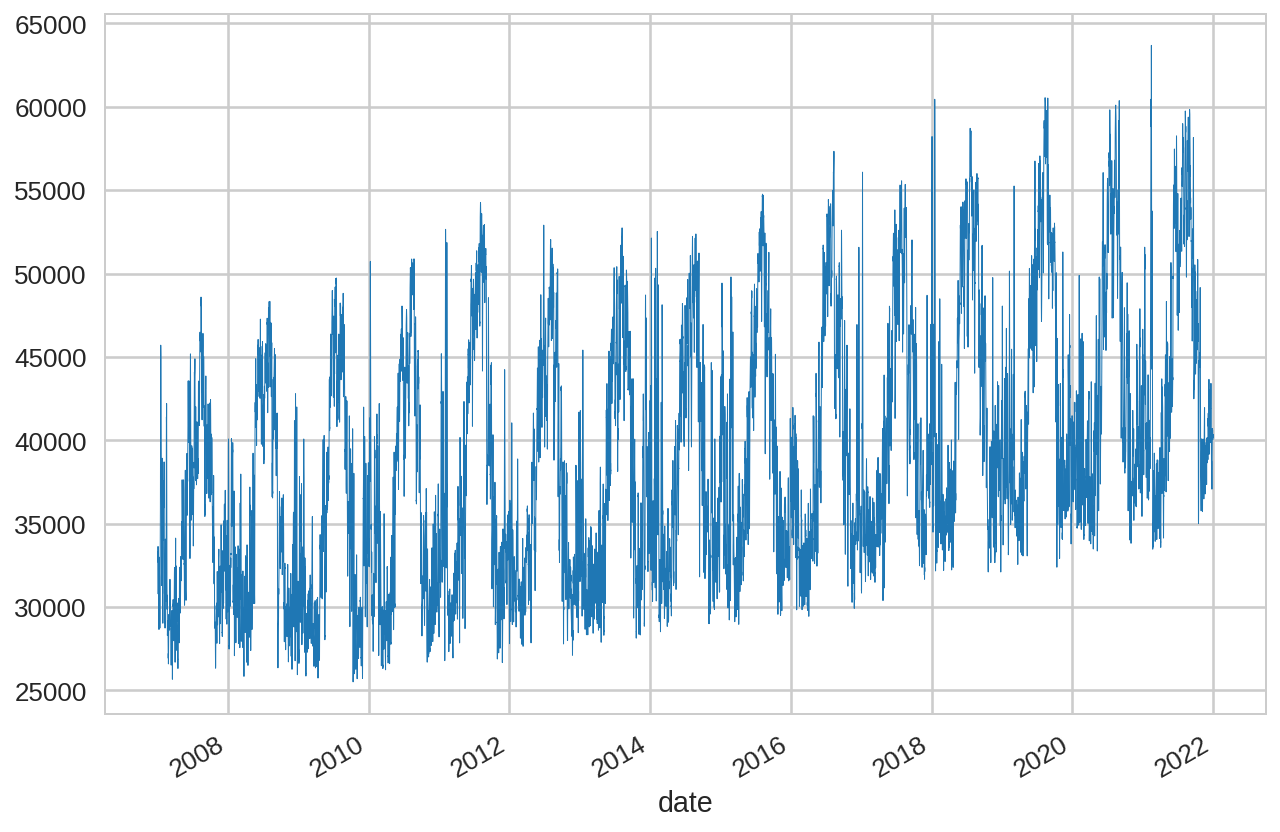

In [83]:
trend = decomposition.trend[12:-12]
trend.plot(linewidth=0.5)

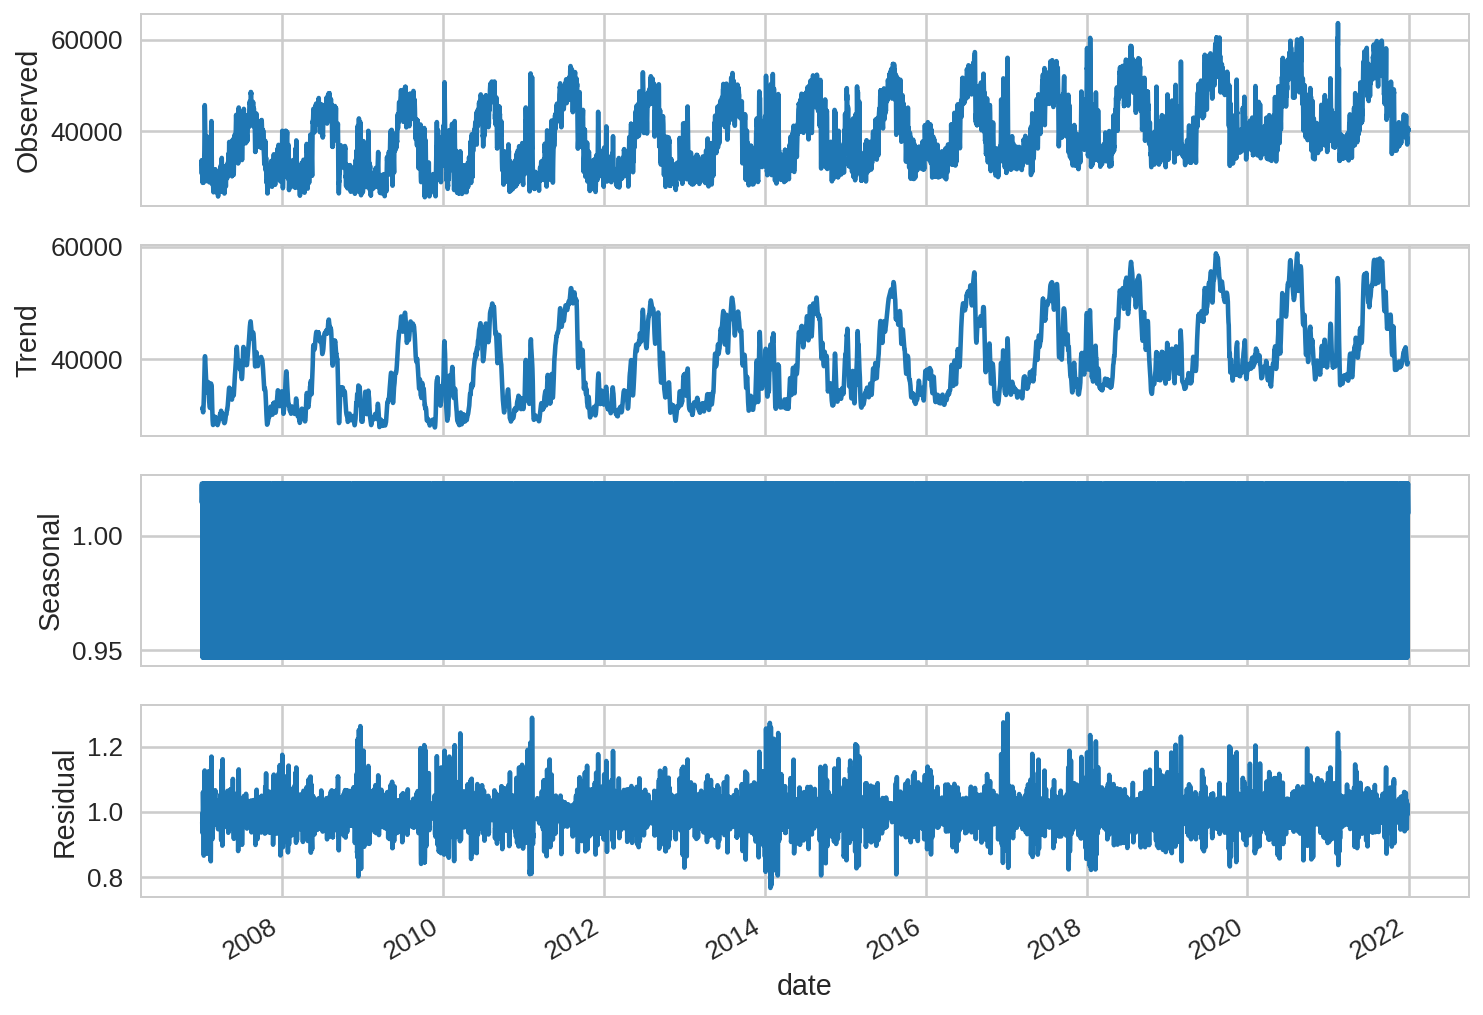

In [84]:
decomposition = seasonal_decompose(trend, model='multiplicative', freq=24*7)  
fig = decomposition.plot()  

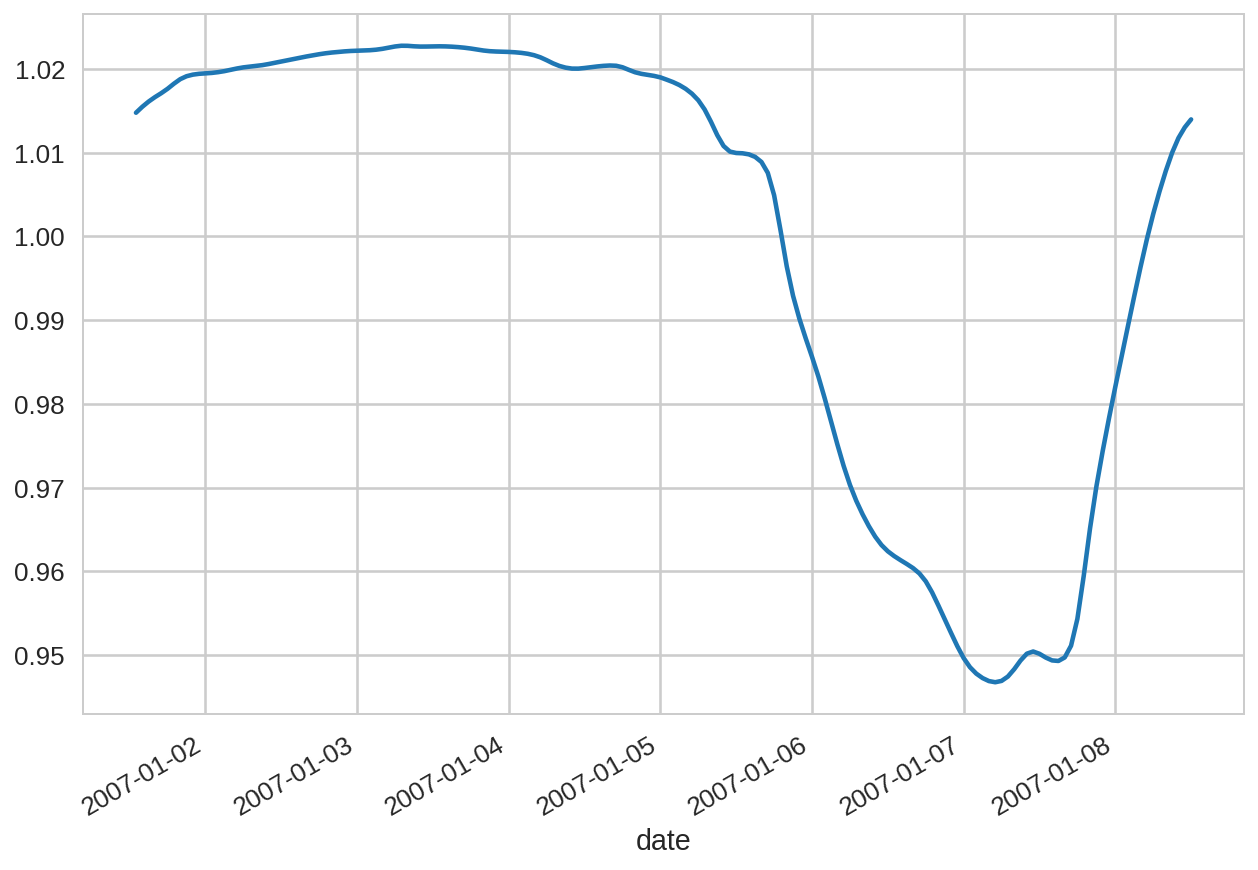

In [85]:
weekly_seasonal = decomposition.seasonal[:24*7]
weekly_seasonal.plot()

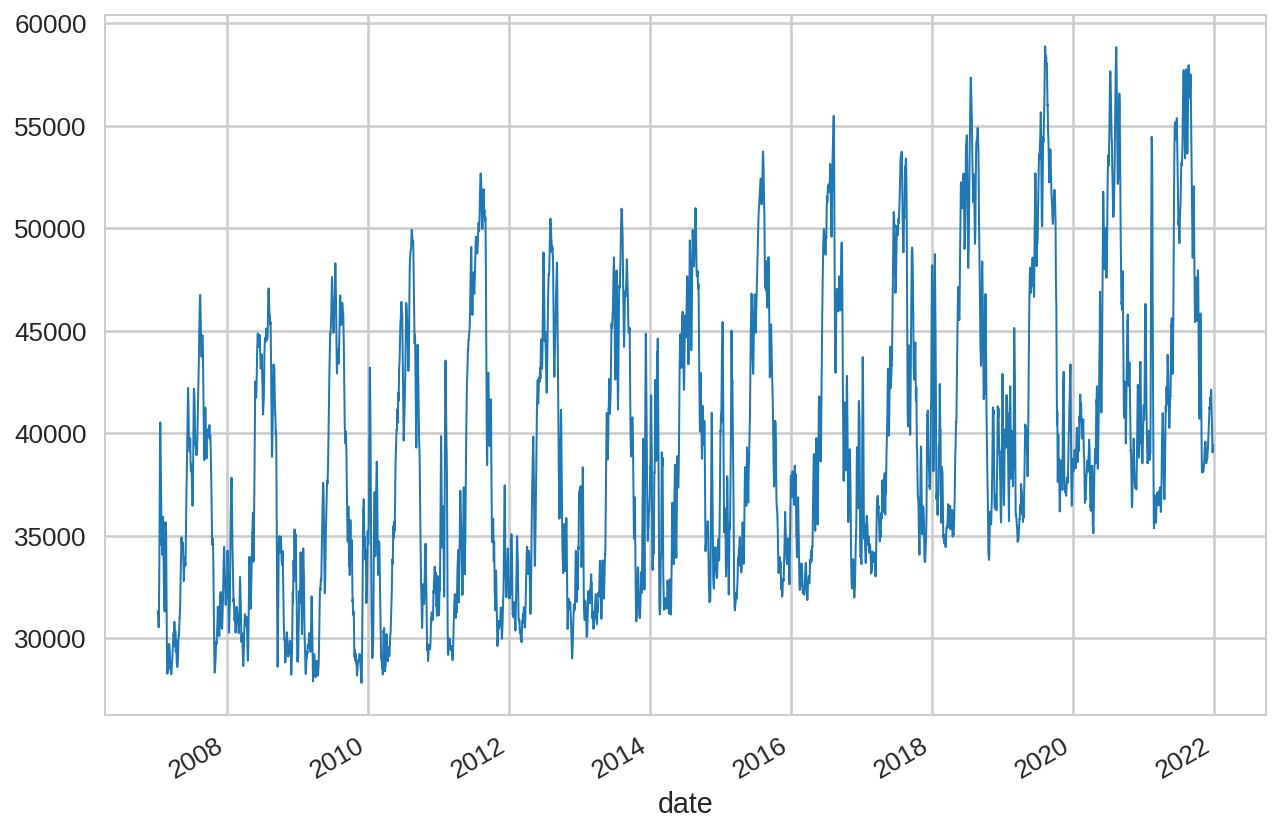

In [86]:
trend = decomposition.trend[12*7:-12*7]
trend.plot(linewidth=1)

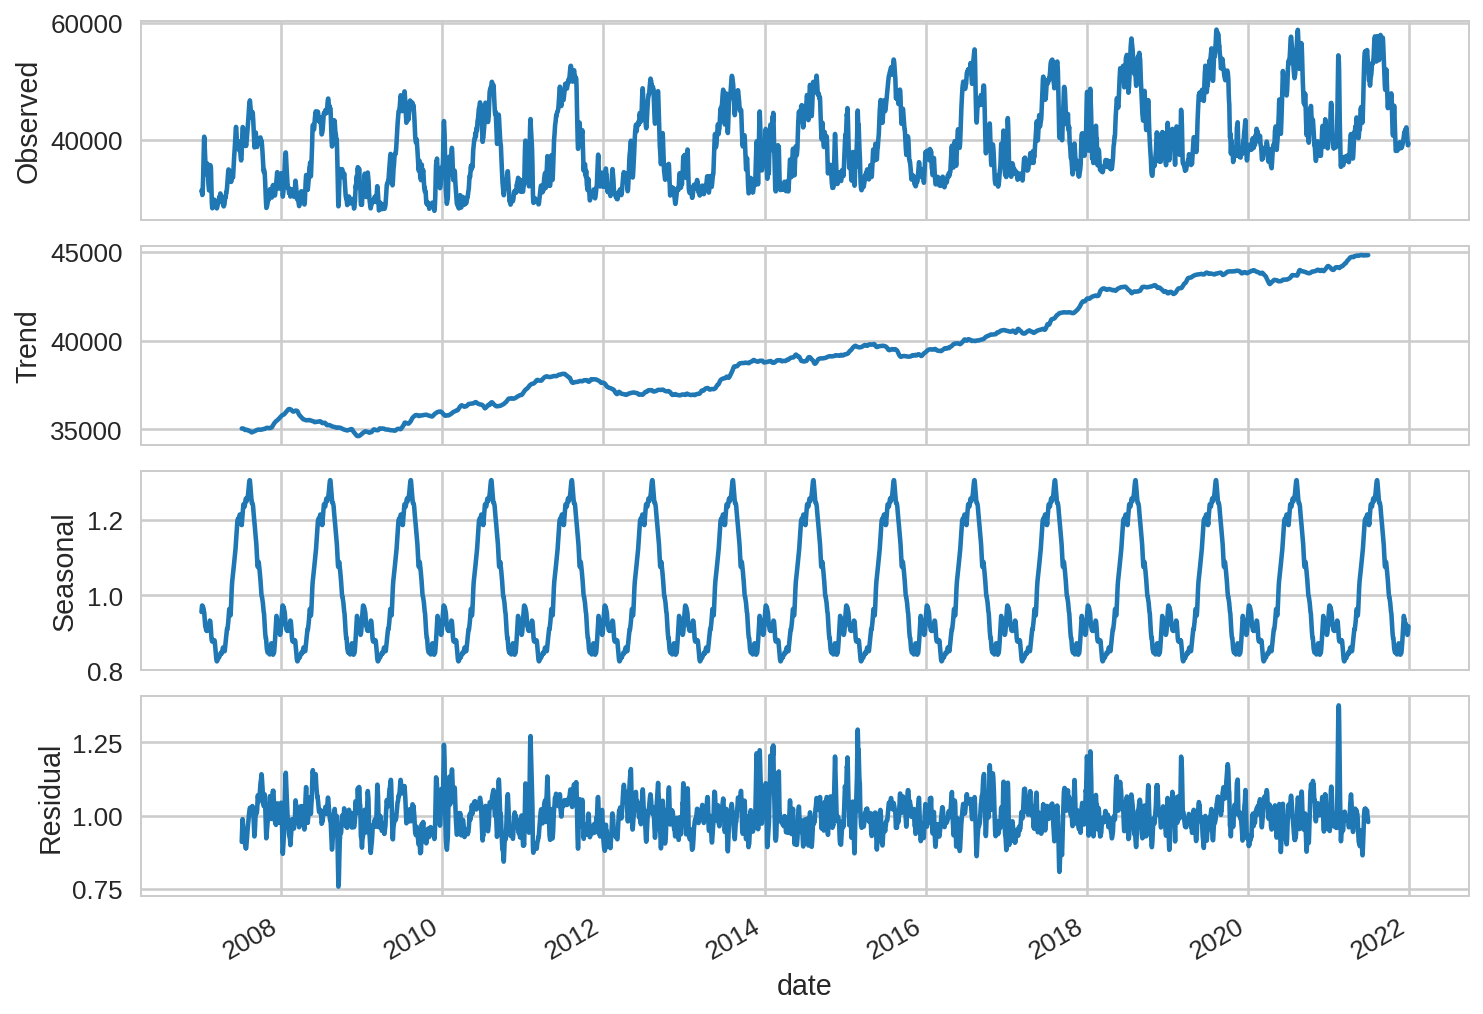

In [87]:
decomposition = seasonal_decompose(trend, model='multiplicative', freq=24*365)  
fig = decomposition.plot()  

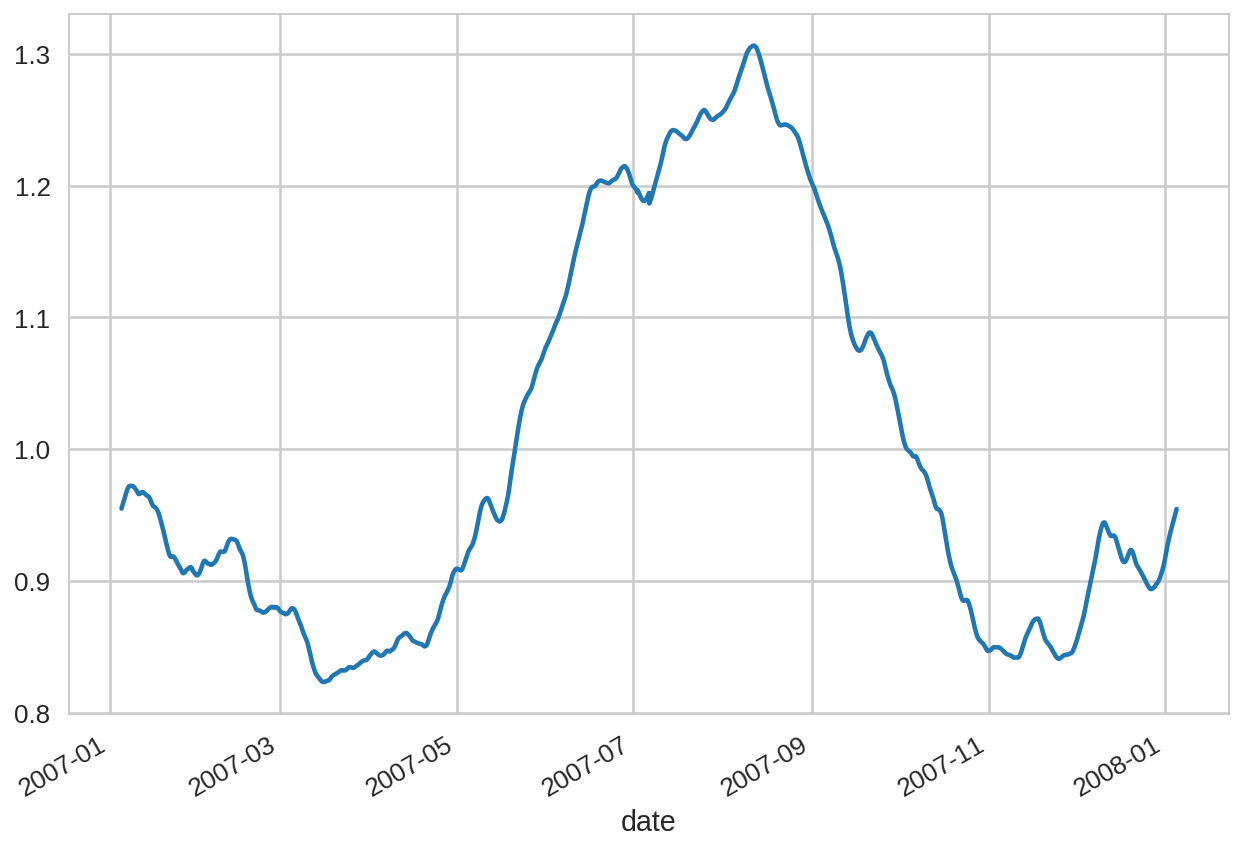

In [88]:
yearly_seasonal = decomposition.seasonal[:24*365]
yearly_seasonal.plot()

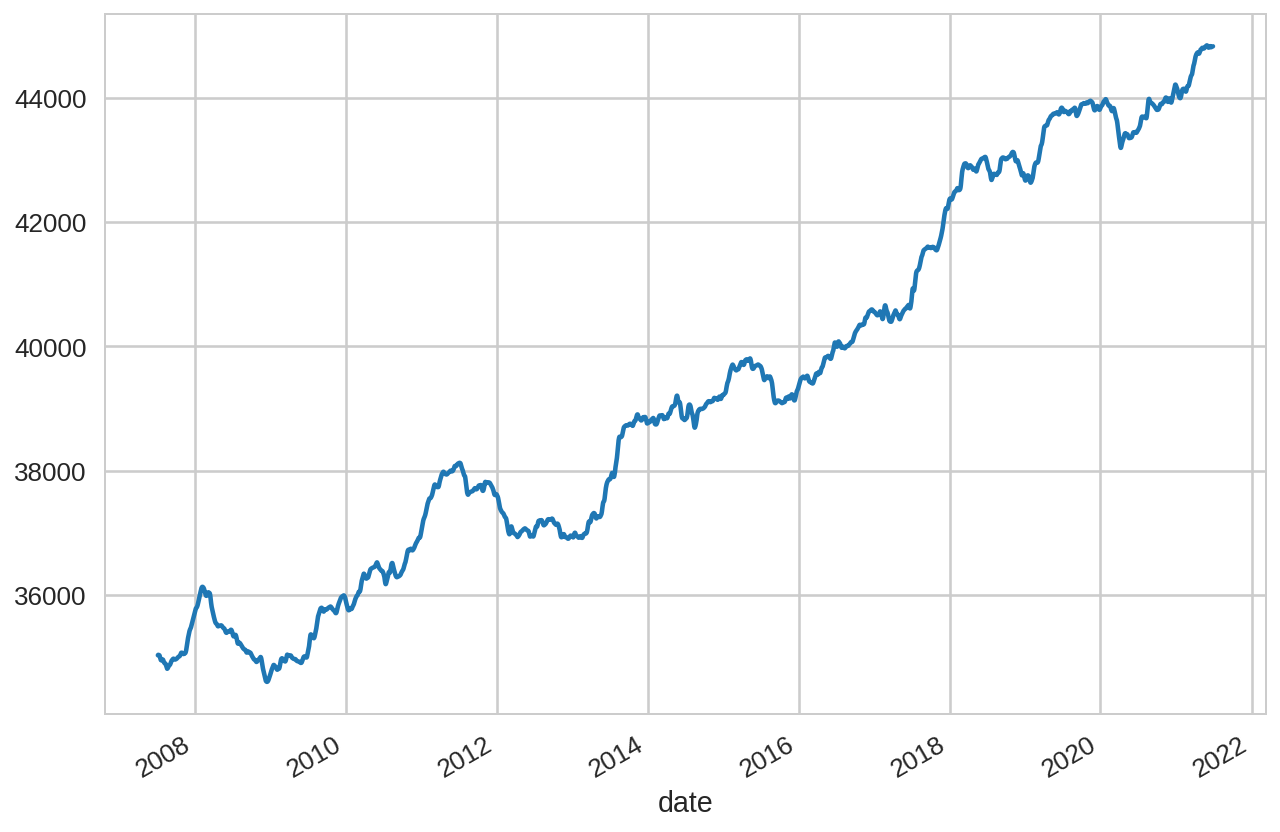

In [89]:
trend = decomposition.trend[365*12:-365*12]
trend.plot()

## FFT

In [90]:
# Detrend the original series, keeping only the seasonal components
y = (df.ERCOT[365*12+12*7+12:-(365*12+12*7+12)] - trend)
y = y - y.mean()

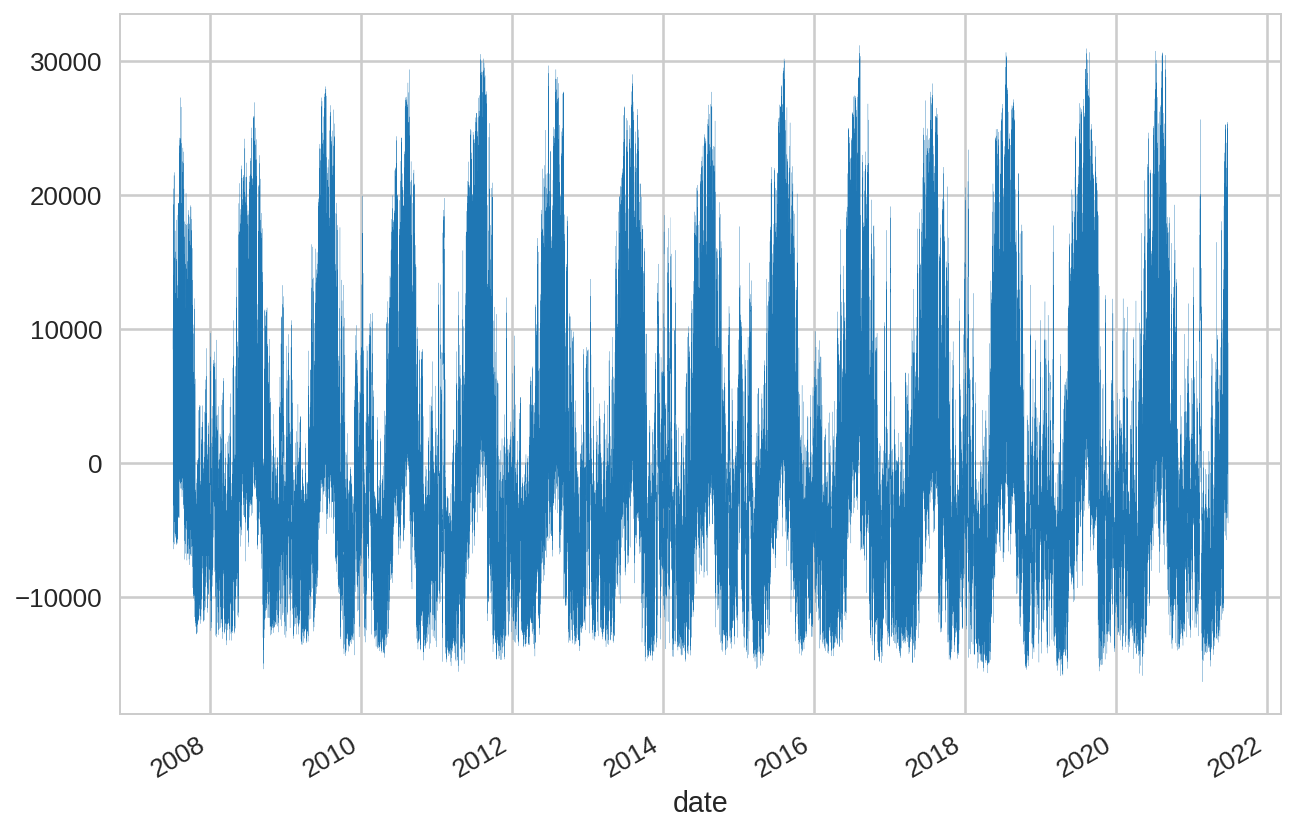

In [91]:
y.plot( linewidth = 0.1 )

In [ ]:
# https://matplotlib.org/gallery/lines_bars_and_markers/spectrum_demo.html
# Apparently Matplotlib has built-in function for plotting spectrum

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# dt = 1  # sampling interval
# Fs = 1 / dt  # sampling frequency

# plot different spectrum types:
# axes[0].set_title("Magnitude Spectrum")
# axes[0].magnitude_spectrum(y, Fs=Fs, color='C1', linewidth=0.5)

# axes[1].set_title("Log. Magnitude Spectrum")
# axes[1].magnitude_spectrum(y, Fs=Fs, scale='dB', color='C1', linewidth=0.5)

In [ ]:
# https://ericstrong.org/fast-fourier-transforms-in-python/

In [92]:
import scipy
import numpy as np

In [93]:
N = len(y)

# Nyquist Sampling Criteria
T = 1 # 1 hour, inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)

yf = scipy.fftpack.dct(y)


logf = np.log(2/N * np.abs(yf[:N//2]))

KeyError: ignored

In [ ]:
len(x)

In [ ]:
x

In [ ]:
len(logf)

In [ ]:
logf

In [ ]:
log_spectrum = pd.DataFrame( list(zip(x,logf)) , columns=['Frequency', 'LogMagnitude'] )
log_spectrum['Days'] = 2 * (1/log_spectrum.Frequency) // 24
# log_spectrum.set_index('Days', inplace=True)

In [ ]:
major_frequency = log_spectrum.LogMagnitude.idxmax()
log_spectrum.iloc[major_frequency] # expressed in days

In [ ]:
log_spectrum.plot.scatter(x='Frequency', y='LogMagnitude', s=1, alpha=0.5, ylim=(-5,15), xlim=(0.01,0.5))

In [ ]:
log_spectrum.set_index('Frequency')['LogMagnitude'].plot(linewidth=0.5, alpha=0.8, ylim=(-5,15))